In [92]:
import ctypes
import os
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.dpi'] = 300

In [93]:
rescale = lambda x: (x - np.min(x)) / np.ptp(x)

# MAIN

In [94]:
dirname = '../src/model_ctypes/_grandi/'
filename_so = os.path.join(dirname, 'model.so')

filename_so_abs = os.path.abspath(filename_so)

model = ctypes.CDLL(filename_so_abs)

model.run.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS')
]
model.run.restype = ctypes.c_int


model.run_algebraic.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'), # double *S
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'), # double *C
    ctypes.c_int, # int n_beats
    ctypes.c_double, # double t_sampling
    ctypes.c_double, # double tol
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS'), # double *output
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS'), # double *output_A
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS') # double *output_t
]

model.run_algebraic.restype = ctypes.c_int


legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')['value']
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']
legend_algebraic = pd.read_csv(os.path.join(dirname, "legend_algebraic.csv"), index_col='name')

In [95]:
# model.initialize_states_default.argtypes = [
#     np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
# ]
# model.initialize_states_default.restype = ctypes.c_void_p


# model.initialize_constants_default.argtypes = [
#     np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
# ]
# model.initialize_constants_default.restype = ctypes.c_void_p

# values = np.zeros(len(legend_states))
# model.initialize_states_default(values)
# legend_states['value'] = values

# values = np.zeros(len(legend_constants))
# model.initialize_constants_default(values)
# legend_constants['value'] = values

In [96]:
# legend_constants[['name', 'value', 'units', 'component']].to_csv(os.path.join(dirname, "legend_constants.csv"), index=False)
# legend_states[['name', 'value', 'units', 'component']].to_csv(os.path.join(dirname, "legend_states.csv"), index=False)
# legend_algebraic[['name', 'value', 'units', 'component']].to_csv(os.path.join(dirname, "legend_algebraic.csv"), index=False)

In [97]:
S = legend_states.copy()
C = legend_constants.copy()
A = legend_algebraic.copy()

len(S), len(C), len(A)

(46, 157, 120)

In [6]:
# C = legend_constants.copy()
# C = C.reset_index()
# C[C['name'] == 'Vmax_SRCaP']

In [8]:
output_list = []

In [9]:
for C['fluo_tot'] in 0, 0.01, 0.1, 1.:
    
    t_sampling = 1

    C['stim_period'] = 1000
    stim_period = C['stim_period']
    n_samples_per_stim = int(stim_period / t_sampling)

    n_beats = 100
    tol = 1e-4

    output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
    
    status = model.run(S.values.copy(), C.values.copy(),
                   n_beats, t_sampling, tol, output)
    
    output = pd.DataFrame(output, columns=legend_states.index)[-1001:]
    
    output_list.append(output)

    #plt.plot(rescale(output.Cai_mean.iloc[-2001:]))

In [8]:
C['fluo_tot'] = 0.0

In [9]:
t_sampling = 1

C['stim_period'] = 1000
stim_period = C['stim_period']
n_samples_per_stim = int(stim_period / t_sampling)

n_beats = 100
tol = 1e-4

In [19]:
output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))

status = model.run(S.values.copy(), C.values.copy(),
                   n_beats, t_sampling, tol, output)

output = pd.DataFrame(output, columns=legend_states.index)

print(status)

2


In [10]:
output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
t = np.zeros(n_samples_per_stim * n_beats + 1)

status = model.run_algebraic(S.values.copy(), C.values,
                             n_beats, t_sampling, tol, output,
                             output_A, t)

output = pd.DataFrame(output, columns=legend_states.index)
output_A = pd.DataFrame(output_A, columns=legend_algebraic.index)
print(status)

2


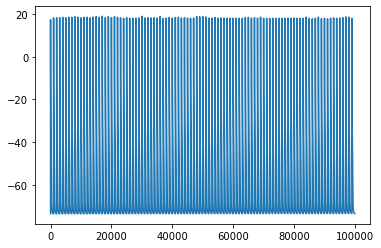

In [11]:
plt.plot(output.V)

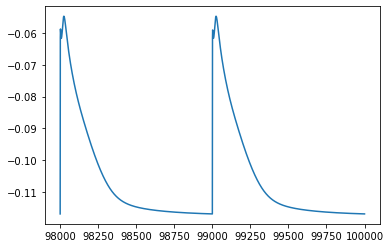

In [12]:
plt.plot(output_A.ICaB.iloc[-2001:])

In [13]:
# output_A = pd.DataFrame(output_A, columns=legend_algebraic.index)

In [14]:
err_abs = output.iloc[-1] - output.iloc[0]
err_rel = err_abs / output.iloc[0] * 100

items = ['Na_i', 'K_i', 'V', 'Ca_i']
# items = ['Nai', 'Ki']

df_err= pd.DataFrame([err_rel[items], err_abs[items]],
                     index=['err_rel', 'err_abs'])
df_err

name,Na_i,K_i,V,Ca_i
err_rel,-0.644273,0.0,-0.092179,-1.476938
err_abs,-0.058964,0.0,0.067691,-0.000003


(-100.0, 2000.0)

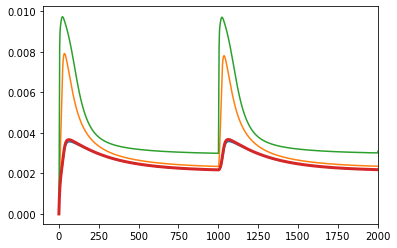

In [15]:
plt.plot(output.fluo_i)
plt.plot(output.fluo_sl)
plt.plot(output.fluo_jn)
plt.plot(output.fluo_mean, lw=3)

plt.xlim(-100, 2000)

(-100.0, 3000.0)

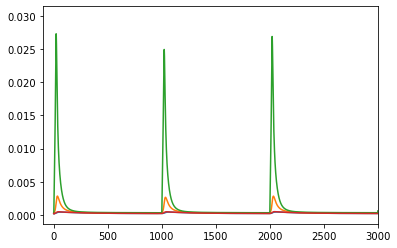

In [19]:
plt.plot(output.Ca_i)
plt.plot(output.Ca_sl)
plt.plot(output.Ca_jn)
plt.plot(output.Cai_mean)

plt.xlim(-100, 3000)

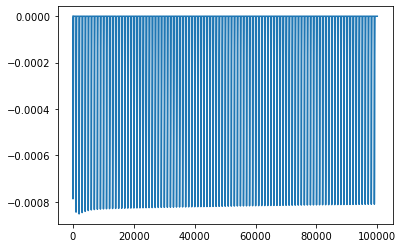

In [20]:
plt.plot(output_A.INaL_jn)

In [21]:
atol = (output.abs().min() / 10).clip(lower=1e-6, upper=1e-3)
atol = np.power(10, np.log10(atol).round())

s = ""
for i, name in enumerate(atol.index):
    x = f'/*{name}*/ {atol[name]}, '
    s += x
    s += (20 - len(x)) * ' '
    if i % 5 == 4:
        s += '\n'

In [22]:
print(s)

/*CaM*/ 0.0001,     /*Myoc*/ 0.001,     /*Myom*/ 0.001,     /*SLH_jn*/ 0.001,   /*SLH_sl*/ 0.001,   
/*SLL_jn*/ 0.001,   /*SLL_sl*/ 0.001,   /*SRB*/ 0.001,      /*TnCHc*/ 0.001,    /*TnCHm*/ 0.001,    
/*TnCL*/ 0.001,     /*Ca_i*/ 1e-05,     /*Ca_jn*/ 0.0001,   /*Ca_sl*/ 1e-05,    /*NaB_jn*/ 0.001,   
/*NaB_sl*/ 0.001,   /*Na_jn*/ 0.001,    /*Na_sl*/ 0.001,    /*Ca_sr*/ 0.001,    /*Csqn*/ 0.001,     
/*V*/ 0.001,        /*d*/ 1e-06,        /*f*/ 0.001,        /*fCaB_jn*/ 0.001,  /*fCaB_sl*/ 0.001,  
/*K_i*/ 0.001,      /*xr*/ 0.0001,      /*xs*/ 0.001,       /*Na_i*/ 0.001,     /*ikur_r*/ 0.0001,  
/*s*/ 0.001,        /*h*/ 1e-06,        /*j*/ 1e-06,        /*m*/ 0.001,        /*hl*/ 0.001,       
/*ml*/ 0.001,       /*x*/ 0.0001,       /*y*/ 0.001,        /*i*/ 1e-06,        /*o*/ 1e-06,        
/*ryr_r*/ 0.001,    /*fluo_i*/ 1e-06,   /*fluo_jn*/ 1e-06,  /*fluo_sl*/ 1e-06,  /*Cai_mean*/ 1e-05, 
/*fluo_mean*/ 1e-06, 


# Fluo-3

In [99]:
result = []

fluo_range = np.logspace(-3, 0, 13)

t_sampling = 1

CL = 1000
C['stim_period'] = CL
stim_period = C['stim_period']
n_samples_per_stim = int(stim_period / t_sampling)

n_beats = 1000
tol = 1e-4

output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
t = np.zeros(n_samples_per_stim * n_beats + 1)

output = pd.DataFrame(output, columns=legend_states.index)
output_A = pd.DataFrame(output_A, columns=legend_algebraic.index)
    
for C['fluo_tot'] in fluo_range:

    status = model.run_algebraic(S.values.copy(), C.values,
                                 n_beats, t_sampling, tol, output.values,
                                 output_A.values, t)
    print(status)
    
    result.append([output[-1001:].copy(), output_A[-1001:].copy()])

2
2
2
2
2
2
2
2
2
2
2
2
2


In [100]:
err_abs = output.iloc[-1] - output.iloc[-CL - 1]
err_rel = err_abs / output.iloc[-CL - 1] * 100

items = ['Na_i', 'K_i', 'V', 'Ca_i']
# items = ['Nai', 'Ki']

df_err= pd.DataFrame([err_rel[items], err_abs[items]],
                     index=['err_rel', 'err_abs'])
df_err

name,Na_i,K_i,V,Ca_i
err_rel,4.427215e-06,0.0,0.000364,-4.787107e-04
err_abs,4.032841e-07,0.0,-0.000263,-1.198246e-09


In [101]:
from matplotlib import cm

cmap = cm.viridis

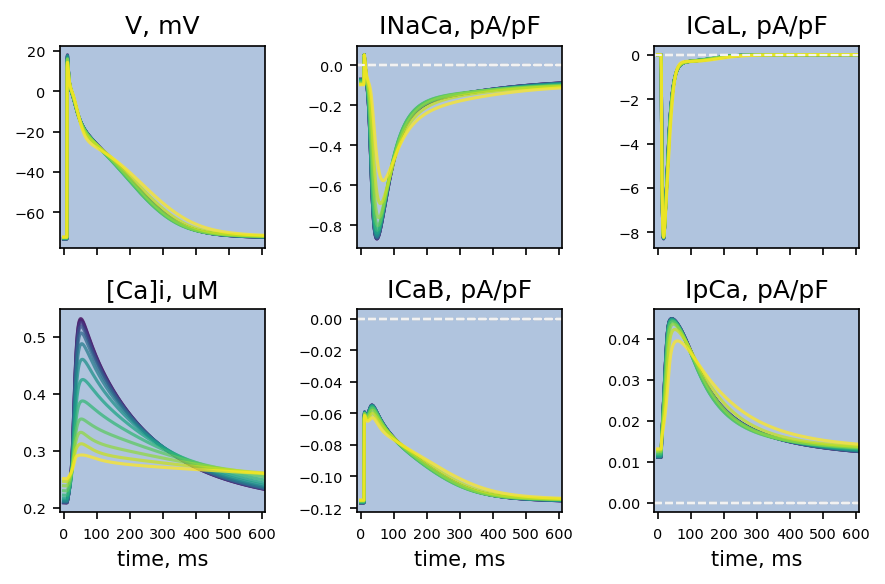

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, dpi=150)

axes = axes.flatten()

keys = ['V', 'INaCa', 'ICaL',
        'Cai_mean', 'ICaB', 'IpCa']

titles = ['V, mV', 'INaCa, pA/pF', 'ICaL, pA/pF',
          '[Ca]i, uM', 'ICaB, pA/pF', 'IpCa, pA/pF']

for i_key, (key, ax) in enumerate(zip(keys, axes)):
    for i_pair, pair in enumerate(result):
        for df in pair:
            if key in df:
                
                x = df[key].values.copy()
                x = np.roll(x, 10)
                    
                if key == 'Cai_mean':
                    x *= 1000
                
                if False: # fluo_range[i_pair] == 0.01:
                    color = 'C3'
                    zorder = 10
                else:
                    color = cmap(i_pair / (len(result) - 1))
                    zorder = -1
                    
                ax.plot(x, color=color, alpha=0.75, zorder=zorder)
                ax.set_title(key)
                
                if key.startswith('I'):
                    ax.axhline(0, ls='--', color='0.95', lw=1, zorder=-1)
                    
                ax.set_title(titles[i_key])
                
                ax.set_facecolor('lightsteelblue')
                
                ax.set_xticks(np.arange(0, 650, 100))
                
                ax.tick_params(labelsize='x-small')
                
                if ax.is_last_row():
                    ax.set_xlabel('time, ms')
                    
plt.xlim(-10, 610)
plt.tight_layout()

plt.savefig("../images/fluo/grandi_currents.pdf")

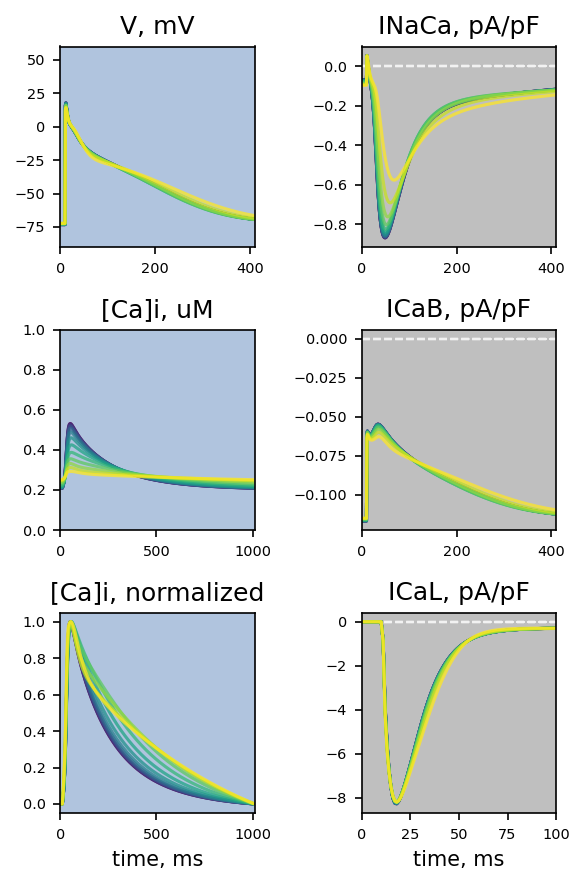

In [104]:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         figsize=plt.figaspect(3 / 2),
                         #sharex=True,
                         dpi=150)

axes = axes.T.flatten()

keys = ['V', 'Cai_mean', 'Cai_mean', 'INaCa', 'ICaB', 'ICaL']

titles = ['V, mV', '[Ca]i, uM', '[Ca]i, normalized', 'INaCa, pA/pF', 'ICaB, pA/pF', 'ICaL, pA/pF']

xlims = [(0, 410),
         (0, 1010),
         (0, 1010),
         (0, 410),
         (0, 410),
         (0, 100),]

for i_key, (key, ax) in enumerate(zip(keys, axes)):
    for i_pair, pair in enumerate(result):
        for df in pair:
            if key in df:
                
                x = df[key].values.copy()
                x = np.roll(x, 10)
                
                if key.startswith('I'):
                    ax.axhline(0, ls='--', color='0.95', lw=1, zorder=-1)
                    
                if key == 'Cai_mean':
                    x *= 1000
                    if i_key == 2:
                        x = rescale(x)
                
                if False: # fluo_range[i_pair] == 0.01:
                    color = 'C3'
                    zorder = 10
                else:
                    color = cmap(i_pair / (len(result) - 1))
                    zorder = 0
                    
                ax.plot(x, color=color, alpha=0.75, zorder=zorder)
                ax.set_title(key)
                    
                ax.set_title(titles[i_key])
                
                facecolor = 'lightsteelblue' if i_key <= 2 else '0.75'
                ax.set_facecolor(facecolor)
                
                #ax.set_xticks(np.arange(0, 650, 100))
                
                ax.tick_params(labelsize='x-small')
                
                if ax.is_last_row():
                    ax.set_xlabel('time, ms')
                    
                ax.set_xlim(xlims[i_key])
                
                if key == 'V':
                    ax.set_ylim(-90, 60)
                    
                if i_key == 1:
                    ax.set_ylim(0, 1)
                    
plt.tight_layout()

plt.savefig("../images/fluo/grandi_currents_v2.png")

# Syn

In [16]:
from tqdm.auto import tqdm

In [18]:
t_sampling = 1


for stim_period in tqdm([2000, 1000, 666, 500, 250]):
    
    C['stim_period'] = stim_period
    n_samples_per_stim = int(stim_period / t_sampling)

    n_beats = 1000
    tol = 1e-6

    output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
    # output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
    # t = np.zeros(n_samples_per_stim * n_beats + 1)
    
    status = model.run(S.values.copy(), C.values.copy(),
                   n_beats, t_sampling, tol, output)

    print(status)
    
    output = pd.DataFrame(output, columns=legend_states.index)

    phenotype = output[-stim_period - 1:][:1000]
    state = phenotype.iloc[0]
    
    dirname = "../data/grandi/syn/"
    
    phenotype_filename = os.path.join(dirname, f'phenotypes/phenotype_{stim_period}.csv')
    state_filename = os.path.join(dirname, f'states/state_{stim_period}.txt')
    
    phenotype.to_csv(phenotype_filename, index=False)
    np.savetxt(state_filename, state)

  0%|          | 0/5 [00:00<?, ?it/s]

2
2
2
2
2


  0%|          | 0/4 [00:00<?, ?it/s]

Na_i       8.209753
K_i      120.000000
Ca_sr      0.491522
Name: 999, dtype: float64
Na_i       9.051097
K_i      120.000000
Ca_sr      0.504631
Name: 999, dtype: float64
Na_i       9.758013
K_i      120.000000
Ca_sr      0.511037
Name: 666, dtype: float64
Na_i      10.333390
K_i      120.000000
Ca_sr      0.518773
Name: 500, dtype: float64


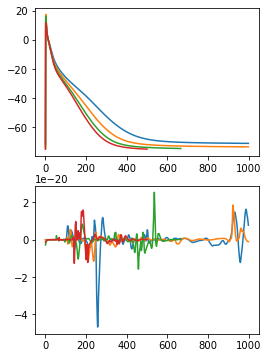

In [19]:
fig, axes = plt.subplots(nrows=2, figsize=plt.figaspect(1.5))

for stim_period in tqdm([2000, 1000, 666, 500]):
    
    dirname = "../data/grandi/syn/"
    phenotype_filename = os.path.join(dirname, f'phenotypes/phenotype_{stim_period}.csv')
    df = pd.read_csv(phenotype_filename)
    
    axes[0].plot(df.V)
    #axes[1].plot(df.Cai_mean)
    axes[1].plot(df.fluo_mean)

    
    print(df.iloc[-1][['Na_i', 'K_i', 'Ca_sr']])

# Prepare (old)

In [11]:
with open("../src/model_ctypes/_grandi/model.c") as f:
    lines = f.readlines()[6:345]
    
lines[:5]

[' * CONSTANTS[0] is Bmax_CaM in component buffca (mM).\n',
 ' * CONSTANTS[128] is Bmax_SLhighj in component buffca (mM).\n',
 ' * CONSTANTS[133] is Bmax_SLhighsl in component buffca (mM).\n',
 ' * CONSTANTS[129] is Bmax_SLlowj in component buffca (mM).\n',
 ' * CONSTANTS[134] is Bmax_SLlowsl in component buffca (mM).\n']

In [43]:
prefixes = ['CONSTANTS', 'STATES', 'ALGEBRAIC']
result = {p: [] for p in prefixes}

for line in lines:
    
    line = line.split()[1:]
    
    x = line[0]
    
    for p in result:
        if x.startswith(p):
            n = int(x[len(p) + 1:-1])
            what = line[2]
            where = line[5]
            units = line[6][1:-2]
            result[p].append([n, what, where, units])

In [44]:
for p, x in result.items():
    result[p] = sorted(x, key = lambda x: x[0])

In [48]:
legend_constants = pd.DataFrame(result['CONSTANTS'], columns=['index', 'name', 'component', 'units']).set_index('index')
legend_constants['value'] = None
legend_constants.head()

,name,component,units,value
index,,,,
0,Bmax_CaM,buffca,mM,None
1,Bmax_SR,buffca,mM,None
2,Bmax_TnChigh,buffca,mM,None
3,Bmax_TnClow,buffca,mM,None
4,Bmax_myosin,buffca,mM,None


In [49]:
legend_states = pd.DataFrame(result['STATES'], columns=['index', 'name', 'component', 'units']).set_index('index')
legend_states['value'] = None
legend_states.head()

,name,component,units,value
index,,,,
0,CaM,buffca,mM,None
1,Myoc,buffca,mM,None
2,Myom,buffca,mM,None
3,SLH_jn,buffca,mM,None
4,SLH_sl,buffca,mM,None


In [66]:
legend_algebraic = pd.DataFrame(result['ALGEBRAIC'], columns=['index', 'name', 'component', 'units']).set_index('index')
legend_algebraic['value'] = 0
legend_algebraic.head()

,name,component,units,value
index,,,,
0,ical_d_inf,ical_d,dimensionless,0
1,ical_f_inf,ical_f,dimensionless,0
2,ikr_xr_inf,ikr_xr,dimensionless,0
3,iks_xs_inf,iks_xs,dimensionless,0
4,ikur_r_inf,ikur_ikur_r,dimensionless,0
